In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from imblearn.over_sampling import SMOTE

# Load the dataset
df = pd.read_csv("E:/assignments/st28629/US_LayOffs/US_LayOffs/Dataset/Iowa_Executive_Branch_Voluntary_and_Involuntary_Employment_Separations.csv")
df.head()

,Record Number,Fiscal Year,Department Name,Sub-Unit of Department,EEO Category Name,Reason,Employee Status,Pay Plan,Pay Grade,Classification Title,Separation Date,Pay Period End Date,Current Fiscal Year
0,12647,2013,"Administrative Services, Department of",NaN,Skilled Craft,Involuntary Dismissal,Permanent (Merit),014,21+13.5%,PAINTER 2,06/22/2012,07/05/2012,False
1,12648,2013,"Commerce, Department of",Insurance Division,Professional,Retirement,Permanent (Merit),014,29,COMPLIANCE OFFICER 1,06/22/2012,07/05/2012,False
2,12649,2013,"Corrections, Department of",Oakdale,Protective Services - Sworn,Retirement,Permanent (Merit),014,23,CORRECTIONAL OFFICER,06/22/2012,07/05/2012,False
3,12650,2013,"Education, Department of",Vocational Rehabilitation,Official/Administrator,Retirement,Permanent (Merit),000,29,EXEC OFF 1,06/22/2012,07/05/2012,False
4,12651,2013,Iowa Workforce Development,NaN,Professional,Retirement,Permanent (Merit),014,30,MANAGEMENT ANALYST 3,06/22/2012,07/05/2012,False


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14499 entries, 0 to 14498
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Record Number           14499 non-null  int64 
 1   Fiscal Year             14499 non-null  int64 
 2   Department Name         14499 non-null  object
 3   Sub-Unit of Department  8312 non-null   object
 4   EEO Category Name       14454 non-null  object
 5   Reason                  14499 non-null  object
 6   Employee Status         14499 non-null  object
 7   Pay Plan                14454 non-null  object
 8   Pay Grade               14454 non-null  object
 9   Classification Title    14454 non-null  object
 10  Separation Date         14499 non-null  object
 11  Pay Period End Date     14499 non-null  object
 12  Current Fiscal Year     14499 non-null  bool  
dtypes: bool(1), int64(2), object(10)
memory usage: 1.3+ MB


In [3]:
df.describe()

,Record Number,Fiscal Year
count,14499.000000,14499.000000
mean,20596.715842,2017.352438
std,4592.388755,2.602261
min,12647.000000,2013.000000
25%,16627.500000,2015.000000
50%,20591.000000,2018.000000
75%,24563.500000,2019.000000
max,28580.000000,2022.000000


In [4]:
# Data Cleaning: Remove duplicates
df.drop_duplicates(inplace=True)

# Convert dates to datetime format
df['Separation Date'] = pd.to_datetime(df['Separation Date'], errors='coerce')
df['Pay Period End Date'] = pd.to_datetime(df['Pay Period End Date'], errors='coerce')
df.head()

,Record Number,Fiscal Year,Department Name,Sub-Unit of Department,EEO Category Name,Reason,Employee Status,Pay Plan,Pay Grade,Classification Title,Separation Date,Pay Period End Date,Current Fiscal Year
0,12647,2013,"Administrative Services, Department of",NaN,Skilled Craft,Involuntary Dismissal,Permanent (Merit),014,21+13.5%,PAINTER 2,2012-06-22,2012-07-05,False
1,12648,2013,"Commerce, Department of",Insurance Division,Professional,Retirement,Permanent (Merit),014,29,COMPLIANCE OFFICER 1,2012-06-22,2012-07-05,False
2,12649,2013,"Corrections, Department of",Oakdale,Protective Services - Sworn,Retirement,Permanent (Merit),014,23,CORRECTIONAL OFFICER,2012-06-22,2012-07-05,False
3,12650,2013,"Education, Department of",Vocational Rehabilitation,Official/Administrator,Retirement,Permanent (Merit),000,29,EXEC OFF 1,2012-06-22,2012-07-05,False
4,12651,2013,Iowa Workforce Development,NaN,Professional,Retirement,Permanent (Merit),014,30,MANAGEMENT ANALYST 3,2012-06-22,2012-07-05,False


In [5]:
# Handle missing values
# Convert 'Pay Grade' to numeric, handling non-numeric values
df['Pay Grade'] = pd.to_numeric(df['Pay Grade'], errors='coerce')  # Convert to numeric, invalid values become NaN

num_imputer = SimpleImputer(strategy='median')
df[['Pay Grade']] = num_imputer.fit_transform(df[['Pay Grade']])

cat_imputer = SimpleImputer(strategy='most_frequent')
df[['Reason', 'Employee Status', 'Sub-Unit of Department']] = cat_imputer.fit_transform(df[['Reason', 'Employee Status', 'Sub-Unit of Department']])


In [6]:
# Feature Engineering
df['Separation Year'] = df['Separation Date'].dt.year
df['Recent Layoff'] = df['Separation Year'] >= 2018
df['Voluntary/Involuntary'] = df['Reason'].apply(lambda x: 'Voluntary' if 'Retirement' in x else 'Involuntary')
df.head()

,Record Number,Fiscal Year,Department Name,Sub-Unit of Department,EEO Category Name,Reason,Employee Status,Pay Plan,Pay Grade,Classification Title,Separation Date,Pay Period End Date,Current Fiscal Year,Separation Year,Recent Layoff,Voluntary/Involuntary
0,12647,2013,"Administrative Services, Department of",Field Operations,Skilled Craft,Involuntary Dismissal,Permanent (Merit),014,24.0,PAINTER 2,2012-06-22,2012-07-05,False,2012,False,Involuntary
1,12648,2013,"Commerce, Department of",Insurance Division,Professional,Retirement,Permanent (Merit),014,29.0,COMPLIANCE OFFICER 1,2012-06-22,2012-07-05,False,2012,False,Voluntary
2,12649,2013,"Corrections, Department of",Oakdale,Protective Services - Sworn,Retirement,Permanent (Merit),014,23.0,CORRECTIONAL OFFICER,2012-06-22,2012-07-05,False,2012,False,Voluntary
3,12650,2013,"Education, Department of",Vocational Rehabilitation,Official/Administrator,Retirement,Permanent (Merit),000,29.0,EXEC OFF 1,2012-06-22,2012-07-05,False,2012,False,Voluntary
4,12651,2013,Iowa Workforce Development,Field Operations,Professional,Retirement,Permanent (Merit),014,30.0,MANAGEMENT ANALYST 3,2012-06-22,2012-07-05,False,2012,False,Voluntary


In [7]:
# Encode categorical features
label_encoder = LabelEncoder()
df['Employee Status Encoded'] = label_encoder.fit_transform(df['Employee Status'])

one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_columns = one_hot_encoder.fit_transform(df[['EEO Category Name']])
encoded_df = pd.DataFrame(encoded_columns, columns=[f"EEO_{col}" for col in one_hot_encoder.get_feature_names_out()])

# Reset index before merging
df = df.reset_index(drop=True)
encoded_df = encoded_df.reset_index(drop=True)

# Drop original categorical column and merge encoded DataFrame
df = df.drop(columns=['EEO Category Name']).join(encoded_df)

# Handle class imbalance using SMOTE
X = df.drop(columns=['Reason'])
y = df['Reason']

# Convert ALL object type columns to numerical using OneHotEncoding
for column in X.select_dtypes(include=['object']).columns:
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded_data = encoder.fit_transform(X[[column]])
    encoded_feature_names = encoder.get_feature_names_out([column])
    encoded_df = pd.DataFrame(encoded_data, columns=encoded_feature_names, index=X.index)
    X = X.drop(columns=[column]).join(encoded_df)

# Check class distribution before SMOTE
print("Class distribution before SMOTE:", Counter(y))

# Apply SMOTE only if there are enough samples
if len(Counter(y)) > 1 and min(Counter(y).values()) >= 2:  # Ensure enough samples for resampling
    smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=2)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    df_resampled = pd.concat([
        pd.DataFrame(X_resampled, columns=X.columns),
        pd.DataFrame(y_resampled, columns=['Reason'])
    ], axis=1)
    print("SMOTE applied successfully.")
else:
    print("Not enough class variation for SMOTE. Proceeding without resampling.")
    df_resampled = df

# Save the processed data
df_resampled.to_csv("processed_layoff_data.csv", index=False)
print("Preprocessing complete. Data saved as 'processed_layoff_data.csv'")


Class distribution before SMOTE: Counter({'Voluntary Resignation': 6272, 'Retirement': 5101, 'Involuntary Dismissal': 1773, 'Involuntary Layoff': 441, 'Disability/Medical': 288, 'Abandoned Job': 200, 'Involuntary Resignation': 186, 'Death': 180, 'Return to Recall': 37, 'Term Expiration': 18, 'Mandatory Retirement': 2, 'Pending Appeal': 1})
Not enough class variation for SMOTE. Proceeding without resampling.
Preprocessing complete. Data saved as 'processed_layoff_data.csv'


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, precision_score, accuracy_score, mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np

In [9]:
# Load processed data
df = pd.read_csv("E:/assignments/st28629/US_LayOffs/US_LayOffs/Dataset/processed_layoff_data.csv")

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14499 entries, 0 to 14498
Data columns (total 24 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Record Number                                      14499 non-null  int64  
 1   Fiscal Year                                        14499 non-null  int64  
 2   Department Name                                    14499 non-null  object 
 3   Sub-Unit of Department                             14499 non-null  object 
 4   Reason                                             14499 non-null  object 
 5   Employee Status                                    14499 non-null  object 
 6   Pay Plan                                           14454 non-null  object 
 7   Pay Grade                                          14499 non-null  float64
 8   Classification Title                               14454 non-null  object 
 9   Separa

In [11]:
df['Reason'].value_counts()

Voluntary Resignation      6272
Retirement                 5101
Involuntary Dismissal      1773
Involuntary Layoff          441
Disability/Medical          288
Abandoned Job               200
Involuntary Resignation     186
Death                       180
Return to Recall             37
Term Expiration              18
Mandatory Retirement          2
Pending Appeal                1
Name: Reason, dtype: int64

In [12]:
# Label encode the 'Reason' column
label_encoder = LabelEncoder()
df['Reason'] = label_encoder.fit_transform(df['Reason'])


In [13]:
# One-hot encode categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)


In [14]:
# Balance the dataset by augmenting minor classes
class_counts = df['Reason'].value_counts()
min_class_count = max(10, class_counts.min())  # Ensure at least 10 samples per class


In [15]:
df_balanced = pd.DataFrame()
for class_label, count in class_counts.items():
    class_subset = df[df['Reason'] == class_label]
    if count < min_class_count:
        class_subset = resample(class_subset, replace=True, n_samples=min_class_count, random_state=42)
    df_balanced = pd.concat([df_balanced, class_subset])

df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle dataset


In [16]:
# Define features and target
X = df_balanced.drop(columns=['Reason'])
y = df_balanced['Reason']


In [17]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [18]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [19]:
# Function to evaluate model performance
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)
    else:
        y_pred_proba = np.zeros((len(y_pred), len(np.unique(y_test))))
    
    auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    return {"AUC": auc, "Precision": precision, "Accuracy": accuracy, "MAE": mae, "MSE": mse, "RMSE": rmse, "MAPE": mape}


### Logistic Regression Model


In [20]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
log_reg_metrics = evaluate_model(log_reg, X_test_scaled, y_test)


### Random Forest Classifier


In [21]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
rf_metrics = evaluate_model(rf_clf, X_test, y_test)

### Extra Trees Classifier


In [22]:
et_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
et_clf.fit(X_train, y_train)
et_metrics = evaluate_model(et_clf, X_test, y_test)


### Gradient Boosting Classifier

In [23]:
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_clf.fit(X_train, y_train)
gb_metrics = evaluate_model(gb_clf, X_test, y_test)

In [24]:
# Print model evaluation results
print("Logistic Regression Metrics:", log_reg_metrics)
print("Random Forest Metrics:", rf_metrics)
print("Extra Trees Metrics:", et_metrics)
print("Gradient Boosting Metrics:", gb_metrics)


Logistic Regression Metrics: {'AUC': 0.8869999322365987, 'Precision': 0.7354709694610745, 'Accuracy': 0.7424242424242424, 'MAE': 1.928030303030303, 'MSE': 15.738636363636363, 'RMSE': 3.967195024653611, 'MAPE': inf}
Random Forest Metrics: {'AUC': 0.9138764119612043, 'Precision': 0.7720276040925608, 'Accuracy': 0.8102617079889807, 'MAE': 1.5285812672176309, 'MSE': 12.797865013774105, 'RMSE': 3.5774103781610105, 'MAPE': inf}
Extra Trees Metrics: {'AUC': 0.9088280873849723, 'Precision': 0.7689509022516834, 'Accuracy': 0.8057851239669421, 'MAE': 1.5557851239669422, 'MSE': 13.048209366391184, 'RMSE': 3.61223052508989, 'MAPE': inf}
Gradient Boosting Metrics: {'AUC': 0.9207936439546457, 'Precision': 0.7607180595447514, 'Accuracy': 0.7992424242424242, 'MAE': 1.5946969696969697, 'MSE': 13.332988980716253, 'RMSE': 3.651436563972631, 'MAPE': inf}


In [25]:
# Train models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Extra Trees": ExtraTreesClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
}

metrics_results = {}

for model_name, model in models.items():
    model.fit(X_train_scaled if "Logistic Regression" in model_name else X_train, y_train)
    metrics_results[model_name] = evaluate_model(model, X_test_scaled if "Logistic Regression" in model_name else X_test, y_test)

# Convert results to DataFrame
metrics_df = pd.DataFrame(metrics_results).T
print(metrics_df)

# Further Analysis
best_model = metrics_df["Accuracy"].idxmax()
print(f"Best model based on accuracy: {best_model}")

# Save results to CSV
metrics_df.to_csv("model_performance_metrics.csv", index=True)
print("Metrics saved to 'model_performance_metrics.csv'")

                          AUC  Precision  Accuracy       MAE        MSE  \
Logistic Regression  0.887000   0.735471  0.742424  1.928030  15.738636   
Random Forest        0.913876   0.772028  0.810262  1.528581  12.797865   
Extra Trees          0.908828   0.768951  0.805785  1.555785  13.048209   
Gradient Boosting    0.920794   0.760718  0.799242  1.594697  13.332989   

                         RMSE  MAPE  
Logistic Regression  3.967195   inf  
Random Forest        3.577410   inf  
Extra Trees          3.612231   inf  
Gradient Boosting    3.651437   inf  
Best model based on accuracy: Random Forest
Metrics saved to 'model_performance_metrics.csv'


In [33]:
import joblib
# Save the best model
joblib.dump(best_model, "best_layoff_model.pkl")
print(f"Best model saved as 'best_layoff_model.pkl'")


Best model saved as 'best_layoff_model.pkl'


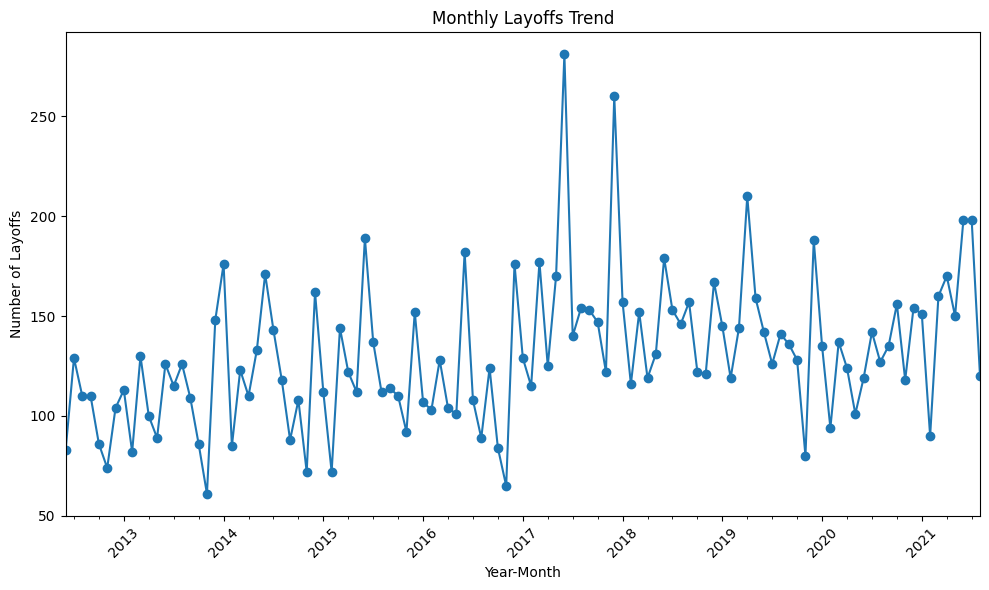

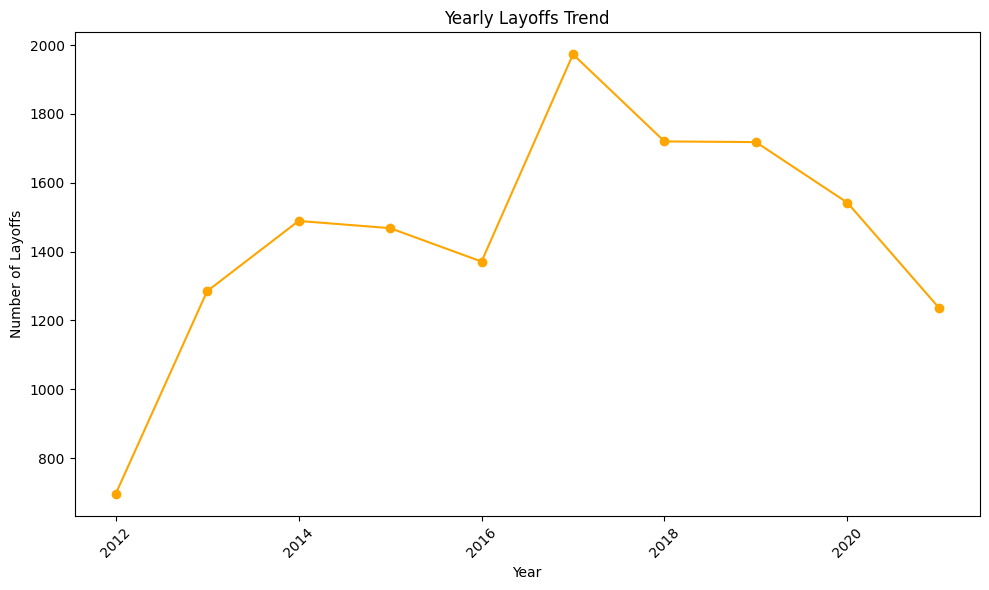

In [29]:
# Load the dataset
df = pd.read_csv("E:/assignments/st28629/US_LayOffs/US_LayOffs/Dataset/Iowa_Executive_Branch_Voluntary_and_Involuntary_Employment_Separations.csv")
# Convert dates to datetime format
df['Separation Date'] = pd.to_datetime(df['Separation Date'], errors='coerce')
df['Pay Period End Date'] = pd.to_datetime(df['Pay Period End Date'], errors='coerce')

# Extract year and month from Separation Date

df['Year'] = df['Separation Date'].dt.year
df['Month'] = df['Separation Date'].dt.month
df['Year-Month'] = df['Separation Date'].dt.to_period('M')

# Count number of layoffs per month
monthly_layoffs = df.groupby('Year-Month').size()

# Count number of layoffs per year
yearly_layoffs = df.groupby('Year').size()

# Visualize trends using line plot
import matplotlib.pyplot as plt

# Monthly trend plot
plt.figure(figsize=(10, 6))
monthly_layoffs.plot(kind='line', marker='o')
plt.title('Monthly Layoffs Trend')
plt.xlabel('Year-Month')
plt.ylabel('Number of Layoffs')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Yearly trend plot
plt.figure(figsize=(10, 6))
yearly_layoffs.plot(kind='line', marker='o', color='orange')
plt.title('Yearly Layoffs Trend')
plt.xlabel('Year')
plt.ylabel('Number of Layoffs')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
